In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm

# Capstone Project - Function 1

## Function 1 - Searching for Contamination sources
**Problem Description** This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

**Acquisition Function found to be the most efficient over time:** Expected Improvement

**Kernel Idea (evolved over time from simple default kernel usage to parametrized kernel based on inputs/outputs and function context):** 
- We want to optimize Kernel parameters
- We know all inputs are between 0 and 1
- We know output is gonna be small or close to 0
- Length scale: we pick up half the input range: 0.5
- Output scale: small to expect the range of results
- Kernel choice: RBF as it is a common choice, however we may want to add a constant and some noise (avoid overfitting): Constant and White Kernels should be used as well

### 1.Loading the available data:
Here we first load the available datasets (1 and 2), then we add our weekly inputs/outputs to the dataset. 

In [5]:
# Loading the baseline data
X = np.load('initial_data/function_1/initial_inputs.npy')
Y = np.load('initial_data/function_1/initial_outputs.npy')
X2 = np.load('initial_data2/function_1/initial_inputs.npy')
Y2 = np.load('initial_data2/function_1/initial_outputs.npy')

#X = np.concatenate((X,X2), dtype = float)
#Y = np.concatenate((Y,Y2), dtype = float)


# Precision notation
np.set_printoptions(suppress=False)

# Adding knwon inputs/outputs from previous weeks
Xn = np.array(
[
    [0.111111, 0.111111],
    [0.630303, 0.664646],
    [0.753627, 0.758346],
    [0.756886, 0.75002],
    [0.75019, 0.759869],
    [0.630465, 0.664784],
    [0.622587, 0.657932],
    [0.619964, 0.655645],
    [0.621372, 0.656875],
    [0.615533, 0.651754],
    [0.616421, 0.652542],
    [0.611323, 0.648059],
    [0.609717, 0.647589],
    [0.613949, 0.646763],
    [0.614629, 0.645873],
    [0.618516, 0.641006],
    [0.618048, 0.64167 ],
    [0.622271, 0.635569],
    [0.627348, 0.62846 ],
    [0.626698, 0.629011]
])
#X = np.concatenate((X,Xn), dtype = float)

Yn = np.array(
[
    1.36*np.exp(-34),
    0.03111818748,
    6.956479*np.exp(-24),
    2.38*np.exp(-23),
    8.50*np.exp(-24),
    0.02925384988,
    0.1774332252,
    0.2416729049,
    0.2071379897,
    0.3347986809,
    0.3191488671,
    0.3710796728,
    0.3351660593,
    0.5205049322,
    0.5926199135,
    1.073856286,
    1.005647838,
    1.615076101,
    1.993162229,
    1.982721484
])
#Y = np.concatenate((Y,Yn), dtype = float)

In [24]:
print("X:\n")
print(X)
print("\n")
print("Y:\n")
print(Y)

X:

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.90048221 0.46996691]
 [0.86243528 0.4352856 ]
 [0.09311333 0.31520745]
 [0.48975434 0.16844847]
 [0.90132685 0.67366454]
 [0.32101719 0.63497061]
 [0.32044659 0.42030664]
 [0.63861791 0.73839723]
 [0.59648578 0.61407967]
 [0.48366726 0.31942835]
 [0.96227495 0.90831843]
 [0.46937596 0.55313941]
 [0.06938944 0.62671938]
 [0.59640851 0.81673367]
 [0.1409109  0.3179331 ]
 [0.58653471 0.20732755]
 [0.61533925 0.18320905]
 [0.9068703  0.76151747]
 [0.58038966 0.57243686]
 [0.55684911 0.58265192]
 [0.111111   0.111111  ]
 [0.630303   0.664646  ]
 [0.753627   0.758346  ]
 [0.756886   0.75002   ]
 [0.75019    0.759869  ]
 [0.630465   0.664784  ]
 [0.622587   0.657932  ]
 [0.619964   0.655645  ]
 [0.621372   0.656875  ]
 [0.615533   0.651754

In [6]:
# We look at and store the max output we obtained until now, and its related input values.
y_max = np.max(Y)
print("Max output until now: ", y_max, "which corresponds to input: ", X[np.where(Y == y_max)][0])

Max output until now:  7.710875114502849e-16 which corresponds to input:  [0.73102363 0.73299988]


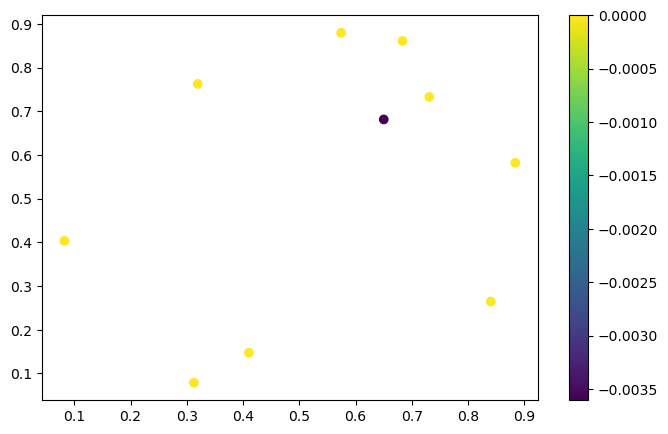

In [7]:
# Plot the two dimensions for visibility, as long as it's less than 4 dimensions, it can help.
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = Y)
plt.colorbar();

### 2. Build a Bayesian Model
Here we will build the bayesian model using Gaussian Process Regression (GPR). This method was explored in the course and is also the method recommended by the litterature.
GPR is widely used in blackbox machine learning models due to its representation flexibility and inherent capability to quantify uncertainty over predictions.

Advantages:
- Flexibility: GPR is a non-parametric method, meaning it makes fewer prior assumptions about the form of the function that maps inputs to outputs.
- Uncertainty Quantification: One of the key advantages of GPR is its ability to provide a measure of uncertainty along with predictions.
- Kernel Functions: GPR uses kernel functions to define the similarity between data points. This allows the model to capture complex patterns and structures in the data. We played with kernel functions during the full capstone project to find the best candidate.
- Prior Knowledge Incorporation: GPR allows for the incorporation of prior knowledge through the use of different kernel functions.
- Surrogate Modeling: GPR is often used as a surrogate model in optimization problems, where the goal is to find the best parameters of a blackbox function that is expensive to evaluate. 

Inconvenients:
- Computation resources: It can be computationally expensive for large datasets, and choosing the right kernel function can be challenging.

#### Approach for Kernel and parameters

We want to optimize Kernel parameters
We know all inputs are between 0 and 1
We know output is gonna be small or close to 0
Length scale: we pick up half the input range: 0.5
Output scale: small to expect the range of results
Kernel choice: RBF as it is a common choice, however we may want to add a constant and some noise (avoid overfitting): 
Constant and White Kernels should be used as well

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W

# Define the kernel function
kernel = C(0.1, (1e-3, 1e1)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e0)) + W(noise_level=1e-4, noise_level_bounds=(1e-5, 1e-2))

# Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=11)
gpr.fit(X, Y)

C:\Users\guill\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=0.316**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=0.0001),
                         n_restarts_optimizer=11)

On top of our GPR model, we need to use an *acquisition function*. 

It will help us to:
- Guide the search: Acquisition functions use the predicted mean and predicted variance generated by the Gaussian process model. They combine these means and variances into a criterion that directs the search. 
    This helps in determining the most promising setting for the next query.
- Balancing Exploration and Exploitation: Acquisition functions help balance the trade-off between exploration (probing areas of the search space where the outcome is uncertain) and exploitation (probing areas where the model predicts a good outcome).
- Efficiency: Since acquisition functions are derived from the mean (μ(x)) and standard deviation (σ(x)) of the Gaussian Process model, they are relatively cheap to compute.
- Selection of New Points: In Gaussian-process optimization, acquisition functions are used to select new points in the search-space to evaluate.

**Which acquisition function to use?**

During our captstone weeks, we identified several acquisition functions (AF) from the literature: Upper Confidence Bound, Expected Improvement, Thompson Sampling, Bayesian Expected Losses, Probability of Improvement...
We decided to compare each AF each week based on the new outputs received to get several inputs for our next query, and take the best one(s) each week based on the model prediction for these AF inputs.
Some of these AF were computationally to expense for a larger number of dimensions but allowed to have more efficiency in the "guessing" process over the weeks.

### 3. Acquisition Function 1 - Upper Confidence Bound

Upper-Confidence Bound action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation. Since there is inherent uncertainty in the accuracy of the action-value estimates when we use a sampled set of rewards thus UCB uses uncertainty in the estimates to drive exploration.
We started the captstone with high exploration (ucb = mean + 1.96 * standard_deviation) but ended up with more exploitation (1.96 -> 0.86) when inputs were converging. 

In [27]:
# To optimize the acquisition function, we will simply use gridsearch over a space of 250.000 gridpoints
# We want to stay close to the local maxima
x1 = np.linspace(X[np.where(Y == y_max)][0][0]-0.07, X[np.where(Y == y_max)][0][0]+0.07, 2000)
x2 = np.linspace(X[np.where(Y == y_max)][0][1]-0.07, X[np.where(Y == y_max)][0][1]+0.07, 2000)
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])
X_grid = np.array(X_grid)

mean, std = gpr.predict(X_grid, return_std = True)

# Previous weeks 
# ucb = mean + 1.86 * std
# ucb = mean + 0.96 * std
# ucb = mean + 0.86 * std

ucb = mean + 0.76 * std

idx_max = np.argmax(ucb)
UB_NextQuery = X_grid[idx_max]
print("UCB - Next Query: ", UB_NextQuery)

UCB - Next Query:  [0.62920393 0.62870512]


### 4. Acquisition Function 2 - Probability of Improvement

The Probability of Improvement (PI) is an acquisition function which chooses the next query point as the one which has the highest probability of improvement over the current best observation. 
In other words, for each candidate point x, it assigns the probability of f(x) being larger than our current best f(x*). 
This helps balance the trade-off between exploration (probing areas of the search space where the outcome is uncertain) and exploitation (probing areas where the model predicts a good outcome).

In [29]:
# Compute PI values for candidate points
def compute_pi(x):
    mu, sigma = gpr.predict(X_grid, return_std = True)
    z = (mu - y_max) / sigma
    pi = norm.cdf(z)
    return pi

# Evaluate PI for a range of candidate points
pi_values = compute_pi(X_grid)

# Choose the next point with maximum PI value
next_idx = np.argmax(pi_values)
PI_NextQuery = X_grid[next_idx]

print("PI - Next Query: ", PI_NextQuery)

PI - Next Query:  [0.62780323 0.6278647 ]


### 5. Acquisition Function 3 - Thompson Sampling

Thompson Sampling is a heuristic for decision-making problems that balances exploration and exploitation. It works by sampling parameters from the posterior distribution, then choosing the action that maximizes the expected reward.

In [18]:
# We take a smaller grid due to computational needs
x1 = np.linspace(X[np.where(Y == y_max)][0][0]-0.07, X[np.where(Y == y_max)][0][0]+0.07, 1000)
x2 = np.linspace(X[np.where(Y == y_max)][0][1]-0.07, X[np.where(Y == y_max)][0][1]+0.07, 1000)
X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        X_grid.append([x1[i], x2[j]])
X_grid = np.array(X_grid)

# Compute Thompson Sampling values for candidate points
def compute_thompson(x):
    mu, sigma = gpr.predict([x], return_std=True)
    sample = np.random.normal(mu, sigma)
    return sample

thompson_values = [compute_thompson(x) for x in X_grid]

# Choose the next point with maximum Thompson Sampling value
next_idx = np.argmax(thompson_values)
TS_NextQuery = X_grid[next_idx]

print("Thompson Sampling - Next Query: ", TS_NextQuery)

Thompson Sampling - Next Query:  [0.6398011  0.63188387]


### 6. Acquisition Function 4 - Bayesian Expected Losses

Bayesian Expected Loss is the expected value of a loss function with respect to the posterior distribution. It's used in decision-making to compare actions, where the preferred action is the one for which the posterior expected loss is smaller. This concept is central to Bayesian decision theory.

In [19]:
# Compute the expected loss for candidate points
def compute_expected_loss(x):
    mu, sigma = gpr.predict([x], return_std=True)
    z = (mu - y_max) / sigma
    expected_loss = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
    return expected_loss

expected_loss_values = [compute_expected_loss(x) for x in X_grid]

# Choose the next point with minimum expected loss
next_idx = np.argmin(expected_loss_values)
BL_NextQuery = X_grid[next_idx]

print("Bayesian Expected Loss - Next Query: ", BL_NextQuery)

Bayesian Expected Loss - Next Query:  [0.556698   0.57989188]


### 7. Acquisition Function 5 - Expected Improvement

Expected Improvement (EI) is an acquisition function which selects the next point to sample by maximizing the expected improvement over the current best estimate. Unlike Probability of Improvement, EI considers not just the probability, but also the magnitude of the potential improvement.

In [30]:
# Compute Expected Improvement for candidate points
def compute_expected_improvement(x):
    mu, sigma = gpr.predict([x], return_std=True)
    f_best = np.max(Y)
    z = (mu - f_best) / sigma
    ei = (mu - f_best) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

ei_values = [compute_expected_improvement(x) for x in X_grid]

# Choose the next point with maximum EI value
next_idx = np.argmax(ei_values)
EI_NextQuery = X_grid[next_idx]

print("Expected Improvement - Next Query: ", EI_NextQuery)



KeyboardInterrupt



## Predict Output for next query: select next inputs
Based on the next queries found using our set of acquisition functions, we use the prediction of the model to see which prediction would maximizse the output (potentially) and send the top 1 or 2 each week to the form. 

In [21]:
formatted_UCB = "{}{:.6f}-{:.6f} -> {}".format("UCB: ",UB_NextQuery[0],UB_NextQuery[1], gpr.predict([UB_NextQuery]))
formatted_PI = "{}{:.6f}-{:.6f} -> {}".format("PI: ",PI_NextQuery[0],PI_NextQuery[1], gpr.predict([PI_NextQuery]))
formatted_TS = "{}{:.6f}-{:.6f} -> {}".format("TS: ",TS_NextQuery[0],TS_NextQuery[1], gpr.predict([TS_NextQuery]))
formatted_BL = "{}{:.6f}-{:.6f} -> {}".format("BL: ",BL_NextQuery[0],BL_NextQuery[1], gpr.predict([BL_NextQuery]))
formatted_EI = "{}{:.6f}-{:.6f} -> {}".format("EI: ",EI_NextQuery[0],EI_NextQuery[1], gpr.predict([EI_NextQuery]))

print(formatted_UCB)
print(formatted_PI)
print(formatted_TS)
print(formatted_BL)
print(formatted_EI)

UCB: 0.629324-0.628696 -> [1.98442034]
PI: 0.627433-0.627995 -> [1.9943626]
TS: 0.639801-0.631884 -> [1.47666258]
BL: 0.556698-0.579892 -> [0.00059889]
EI: 0.629431-0.628801 -> [1.98246978]
